In [59]:
import numpy as np
import matplotlib.pyplot as plt
import math

#for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct

In [44]:
from UserClass import *
from basic_environments import *
from basic_learners import *

In [79]:
%run DATA_users.py
%run DATA_parameters.py

# Step 5

### Environment

In [5]:
class NS_Environment:
    def __init__(self, prices, cost, n_daily_clicks, cum_daily_costs, user_class, horizon):
        
        self.userclass = user_class
        self.cost = cost        
        self.prices = prices    
        
        self.pricing_environment = PricingEnvironment(prices, cost, user_class)

        self.n_daily_clicks = max(int(n_daily_clicks), 0)
        self.cum_daily_costs = cum_daily_costs
        self.n_phases = len(user_class.conversion_rate_function(prices))
        self.conversion_probabilities = []
        for i in range(0, self.n_phases):
            self.conversion_probabilities.append([user_class.conversion_rate_function(p)[i] for p in prices])
        self.t = 0
        self.horizon = horizon
        self.phase_size = self.horizon/self.n_phases
        """ 
        here the 3 phases occur just once during the horizon (as seen in lectures).
        another option is to pass the lenght of the phases 
        """

    def round(self, pulled_arm):
        current_phase = int((self.t - self.horizon*int(self.t / self.horizon)) / self.phase_size)
        p = self.conversion_probabilities[current_phase][pulled_arm]
        self.t += 1
        #reward = self.pricing_environment.round(pulled_arm, self.n_daily_clicks, self.cum_daily_costs)[current_phase]
        reward = np.random.binomial(n_daily_clicks, p) * (self.prices[pulled_arm] - self.cost) - self.cum_daily_costs
        return reward

Parameters

In [94]:
# Training parameters
T = 365
n_experiments = 1000
window_size = 4*int(np.sqrt(T))

BID_STEP1 = BIDS[55]

Clairvoyant

In [95]:
n_daily_clicks = int(C1_NS.n_daily_clicks_function(BID_STEP1))
cum_daily_costs = C1_NS.cum_daily_costs_function(BID_STEP1)

opt_val = [0]*3
for i in range(3):
    opt_val[i] = np.max(C1_NS.conversion_rate_function(PRICES)[i] * (PRICES - MARGIN_PARAM)) #optimal value of conversion rate between the arms for each phase

opt = [0]*3
for i in range(3):
    opt[i] = n_daily_clicks * opt_val[i] - cum_daily_costs

opt_arm = [0]*3
for i in range(3):
    opt_arm[i] = np.argmax(C1_NS.conversion_rate_function(PRICES)[i] * (PRICES - MARGIN_PARAM)) #optimal value of conversion rate between the arms for each phase

print("n_daily_clicks: ", n_daily_clicks)
print("cum_daily_costs: ", cum_daily_costs)
print()
print("optimal price phase 1: ", PRICES[opt_arm[0]])
print("optimal price phase 2: ", PRICES[opt_arm[1]])
print("optimal price phase 3: ", PRICES[opt_arm[2]])
print("conversion rate on the optimal price phase 1: ", C1.conversion_rate_function(PRICES[opt_arm[0]]))
print("conversion rate on the optimal price phase 2: ", C1.conversion_rate_function(PRICES[opt_arm[1]]))
print("conversion rate on the optimal price phase 3: ", C1.conversion_rate_function(PRICES[opt_arm[2]]))
print("optimal reward phase 1: ", opt[0])
print("optimal reward phase 2: ", opt[1])
print("optimal reward phase 3: ", opt[2])

n_daily_clicks:  100
cum_daily_costs:  360.0

optimal price phase 1:  60
optimal price phase 2:  50
optimal price phase 3:  70
conversion rate on the optimal price phase 1:  0.5458775937413701
conversion rate on the optimal price phase 2:  0.9
conversion rate on the optimal price phase 3:  0.33109149705429813
optimal reward phase 1:  840.0
optimal reward phase 2:  340.0
optimal reward phase 3:  1440.0


### Sliding Window UCB1

In [7]:
class SW_UCB1_Learner(Learner):
    def __init__(self, n_arms, window_size, support = (0,1)):
       
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)
        self.c = (support[1] - support[0]) * np.sqrt(2)

        self.window_size = window_size 
        self.pulled_arms = np.array([])

    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.pulled_arms = np.append(self.pulled_arms, pulled_arm)
        for arm in range(self.n_arms):
            n_samples = np.sum(self.pulled_arms[-self.window_size:] == arm)
            cum_rew = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
            self.empirical_means[arm] = cum_rew / n_samples
        #-update confidences and means\n",
        for a in range(self.n_arms):
            n_samples = np.sum(self.pulled_arms[-self.window_size:] == a)
            cum_rew = np.sum(self.rewards_per_arm[a][-n_samples:]) if n_samples > 0 else 0
            if n_samples > 0:
                self.confidence[arm] = self.c * np.sqrt(np.log(self.window_size)/n_samples)
                self.empirical_means[a] = cum_rew / n_samples
                self.confidence[a] = self.c * np.sqrt(np.log(self.window_size)/n_samples)
            else:
                self.confidence[arm] = np.inf
                self.empirical_means[a] = 0
                self.confidence[a] = np.inf
        self.update_observations(pulled_arm, reward)

Discounted SW-UCB

In [22]:
class SW_UCB1_Learner(Learner):
    def __init__(self, n_arms, window_size, support = (0,1)):
       
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)
        self.c = (support[1] - support[0]) * np.sqrt(2)

        self.window_size = window_size 
        self.pulled_arms = np.array([])

    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        

        self.pulled_arms = np.append(self.pulled_arms, pulled_arm)

        #-update confidences and means
        for a in range(self.n_arms):
            # discount = np.array([])
            discount = np.zeros(self.t+1 - np.max([self.t - self.window_size + 1, 1]))
            pull_history = self.pulled_arms[-self.window_size:] == a
            n_samples = np.sum(pull_history)
            #for s in range(np.max([self.t - self.window_size + 1, 1]), self.t+1):
            #    discount = np.append(discount, np.power(0.99, self.t-s))
            s = np.arange(np.max([self.t - self.window_size + 1, 1]), self.t+1)
            discount = np.power(0.99, self.t-s)
            n_samples_d = np.sum(discount*pull_history)                      #n_samples = np.sum(self.pulled_arms[-self.window_size:] == a)
            cum_rew = np.sum(self.rewards_per_arm[a][-n_samples:]) if n_samples > 0 else 0
            if n_samples > 0:
                self.empirical_means[a] = cum_rew / n_samples_d
                self.confidence[a] = self.c * np.sqrt(np.log(np.min([self.t, self.window_size]))/n_samples_d)
            else:
                self.empirical_means[a] = 0
                self.confidence[a] = np.inf
            #print('time: ' + str(self.t) + ', arm: ' + str(a) + ', nsamples: ' + str(n_samples_d) + '  ' + str(n_samples) + ', cumrew: ' + str(cum_rew) + ', emp mean: ' + str(self.empirical_means[a]) + ', conf: ' + str(self.empirical_means[a] + self.confidence[a]))
        #print('\n\n')
        self.update_observations(pulled_arm, reward)



In [21]:
class Custom_SW_UCB_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, window_size, M=1):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs

        self.conversion_rate_learner = SW_UCB1_Learner(n_arms, window_size, support=(0,M))


    def pull_arm(self):
        idx_arm = self.conversion_rate_learner.pull_arm()
        return idx_arm


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        alpha = (reward + self.cum_daily_costs) / (self.n_daily_clicks)
        self.conversion_rate_learner.update(pulled_arm, alpha)

## Example

### Running algorithm

In [103]:
## SW_UCB learner
n_experiments = 100

sw_ucb_rewards_per_experiment = []

sw_ucb_conversion_rate_hat = np.zeros(len(PRICES))
sw_ucb_conversion_rate_bound = np.zeros(len(PRICES))

for e in range(0, 100):
    if e%(int(n_experiments/10)) == 0:
        print(f'{e/n_experiments*100}%')
    ns_env = NS_Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1_NS, T)
    sw_ucb_learner = Custom_SW_UCB_Learner(PRICES, n_daily_clicks, cum_daily_costs, window_size, M=12)

    for t in range(0, T):
        pulled_arm = sw_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        sw_ucb_learner.update(pulled_arm, reward)
        
    sw_ucb_rewards_per_experiment.append(sw_ucb_learner.collected_rewards)

    sw_ucb_conversion_rate_hat += sw_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    sw_ucb_conversion_rate_bound += sw_ucb_learner.conversion_rate_learner.confidence/n_experiments

sw_ucb_std_inst = np.std(sw_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
sw_ucb_std_cum = np.std(np.cumsum(sw_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

sw_ucb_mean_rewards_hat = np.mean(sw_ucb_rewards_per_experiment, axis = 0)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


### Plots

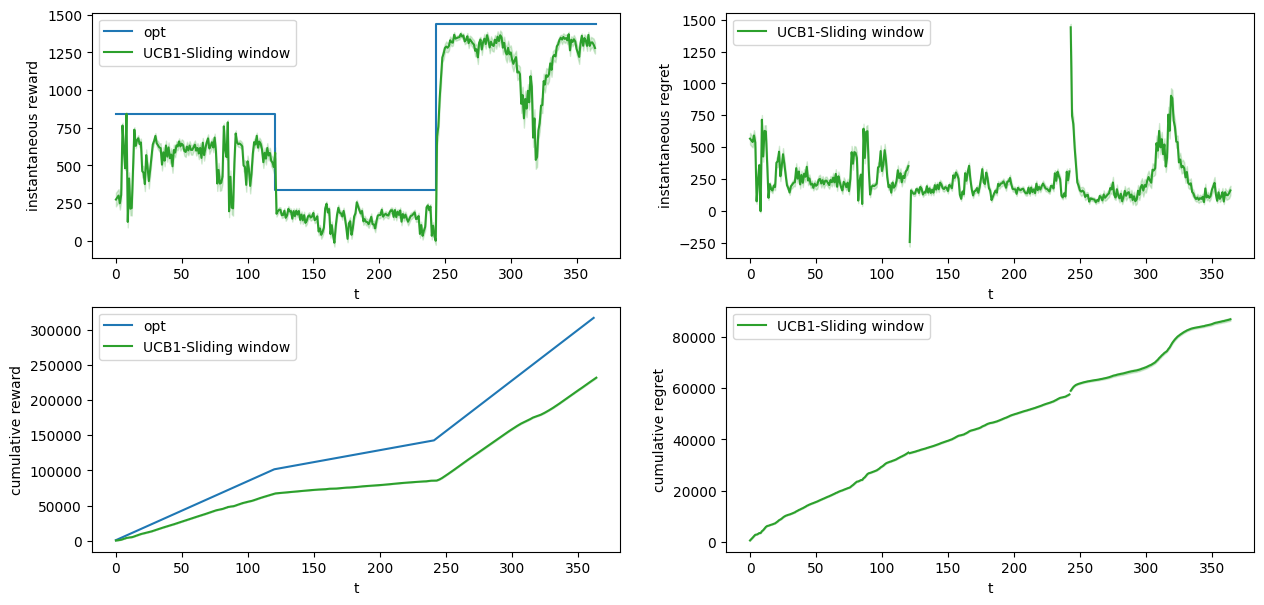

In [104]:
#Plots
plt.figure(figsize = (15,7))

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.step([0, int(T/3), int(2*T/3), T], [opt[0], opt[0], opt[1], opt[2]], label = 'opt')
plt.plot(sw_ucb_mean_rewards_hat, color = 'C2', label = "UCB1-Sliding window")
plt.fill_between(np.arange(T), sw_ucb_mean_rewards_hat - sw_ucb_std_inst, sw_ucb_mean_rewards_hat + sw_ucb_std_inst, alpha = 0.2, color = 'C2') 
plt.legend()

#Instantaneous regret plot
for i in range(3):
    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - sw_ucb_mean_rewards_hat)[int(T*i/3):int(T*(i+1)/3)], color = "C2", label = "UCB1-Sliding window")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - sw_ucb_mean_rewards_hat - sw_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], (opt[i] - sw_ucb_mean_rewards_hat + sw_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C2')
    if i == 0:
        plt.legend()



#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")

temp = np.array([])
for i in range(0, 3):
    temp = np.append(temp, np.full(int(T/3), opt[i]))
plt.plot(np.cumsum(temp), label='opt')

plt.plot(np.cumsum(sw_ucb_mean_rewards_hat), color = "C2", label = "UCB1-Sliding window")
plt.fill_between(np.arange(T), np.cumsum(sw_ucb_mean_rewards_hat) - sw_ucb_std_cum, np.cumsum(sw_ucb_mean_rewards_hat) + sw_ucb_std_cum, alpha = 0.2, color = 'C2')

plt.legend()

#Cumulative regret plot 
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
temp_val_EXP3 = 0
temp_val_sw_UCB1 = 0
temp_val_cd_UCB1 = 0
for i in range(0, 3):
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)),temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]), color = "C2", label = "UCB1-Sliding window")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) - sw_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) + sw_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C2')
    temp_val_sw_UCB1 += np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)])[-1]
    if i == 0:
        plt.legend()



### CUSUM UCB

In [19]:
#CHANGE DETECTION UCB

class CUSUM_UCB1_Learner(Learner):
    def __init__(self, n_arms, support = (0,12)):
        """
        support: tuple
            the support interval of what we are learning
            e.g. in the case we are learning a probability p -> support = (0,1)
        """
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)
        self.c = (support[1] - support[0]) * np.sqrt(2)
        self.p_detections = []
        self.m_detections = []
        self.gp = np.zeros(n_arms)
        self.gm = np.zeros(n_arms)
        self.sp = np.zeros(n_arms)
        self.sm = np.zeros(n_arms)
        self.epsilon = 1
        self.h = 20
        self.M = np.zeros(n_arms)
        self.gpchart = []
        self.gmchart = []
        self.index = 0

    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.index += 1
        self.update_observations(pulled_arm, reward)

        #Model Updating:
        #-update mean
        self.empirical_means[pulled_arm] += (reward - self.empirical_means[pulled_arm]) / self.index
        # it's the same as: self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t

        #-update confidences
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            if n_samples > 0:
                self.confidence[a] = self.c * np.sqrt(np.log(self.index)/n_samples)
            #print('time: ' + str(self.t) + ', arm: ' + str(a) + ', emp mean: ' + str(self.empirical_means[a]) + ', conf: ' + str(self.empirical_means[a] + self.confidence[a]))
        #print('\n\n')
        if self.index <= 75:
            n_samples = len(self.rewards_per_arm[pulled_arm])
            self.M[pulled_arm] += (reward - self.M[pulled_arm]) / n_samples
            self.gpchart.append(0)
            self.gmchart.append(0)
        else:
            self.sp[pulled_arm] = reward - self.M[pulled_arm] - self.epsilon
            self.sm[pulled_arm] = self.M[pulled_arm] - reward - self.epsilon
            self.gp[pulled_arm] = max([0, self.gp[pulled_arm] + self.sp[pulled_arm]])
            self.gm[pulled_arm] = max([0, self.gm[pulled_arm] + self.sm[pulled_arm]])
            self.gpchart.append(max(self.gp))    # for the charts we use only the max, as it's the only one that matters
            self.gmchart.append(max(self.gm))
            if max(self.gp) >= self.h:
                self.p_detections.append(self.t)
                self.empirical_means = np.zeros(self.n_arms)
                self.confidence = np.full(self.n_arms, np.inf)
                self.gp = np.zeros(self.n_arms)
                self.gm = np.zeros(self.n_arms)
                self.sp = np.zeros(self.n_arms)
                self.sm = np.zeros(self.n_arms)
                self.index = 0
                self.M = np.zeros(self.n_arms)
                self.rewards_per_arm = x = [[] for i in range(self.n_arms)]
            elif max(self.gm) >= self.h:
                self.m_detections.append(self.t)
                self.empirical_means = np.zeros(self.n_arms)
                self.confidence = np.full(self.n_arms, np.inf)
                self.gp = np.zeros(self.n_arms)
                self.gm = np.zeros(self.n_arms)
                self.sp = np.zeros(self.n_arms)
                self.sm = np.zeros(self.n_arms)
                self.index = 0
                self.M = np.zeros(self.n_arms)
                self.rewards_per_arm = x = [[] for i in range(self.n_arms)]
                
        

class Custom_CUSUM_UCB_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, cost):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.cost = cost

        self.conversion_rate_learner = CUSUM_UCB1_Learner(n_arms)


    def pull_arm(self):
        # Obs:  the arm that maximizes the conversion rate is the one that maximizes the reward,
        #       so, the following arm is the arm we pull:
        idx_arm = self.conversion_rate_learner.pull_arm()
        
        return idx_arm


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        alpha = (reward + self.cum_daily_costs) / (self.n_daily_clicks)
        self.conversion_rate_learner.update(pulled_arm, alpha)

In [90]:
cusum_ucb_rewards_per_experiment = []
cusum_ucb_gpchart_per_experiment = []
cusum_ucb_gmchart_per_experiment = []

cusum_ucb_conversion_rate_hat = np.zeros(len(PRICES))
cusum_ucb_conversion_rate_bound = np.zeros(len(PRICES))

p_detections = []
m_detections = []

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1_NS, T)
    cusum_ucb_learner = Custom_CUSUM_UCB_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = cusum_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        cusum_ucb_learner.update(pulled_arm, reward)
        
    cusum_ucb_rewards_per_experiment.append(cusum_ucb_learner.collected_rewards)
    cusum_ucb_gpchart_per_experiment.append(cusum_ucb_learner.conversion_rate_learner.gpchart)
    cusum_ucb_gmchart_per_experiment.append(cusum_ucb_learner.conversion_rate_learner.gmchart)

    cusum_ucb_conversion_rate_hat += cusum_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    cusum_ucb_conversion_rate_bound += cusum_ucb_learner.conversion_rate_learner.confidence/n_experiments

    p_detections = p_detections + cusum_ucb_learner.conversion_rate_learner.p_detections
    m_detections = m_detections + cusum_ucb_learner.conversion_rate_learner.m_detections




cusum_ucb_std_inst = np.std(cusum_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
cusum_ucb_std_cum = np.std(np.cumsum(cusum_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

cusum_ucb_mean_rewards_hat = np.mean(cusum_ucb_rewards_per_experiment, axis = 0)
cusum_ucb_mean_gpchart = np.mean(cusum_ucb_gpchart_per_experiment, axis = 0)
cusum_ucb_mean_gmchart = np.mean(cusum_ucb_gmchart_per_experiment, axis = 0)

number of positive detections: 1000
number of negative detections: 1000


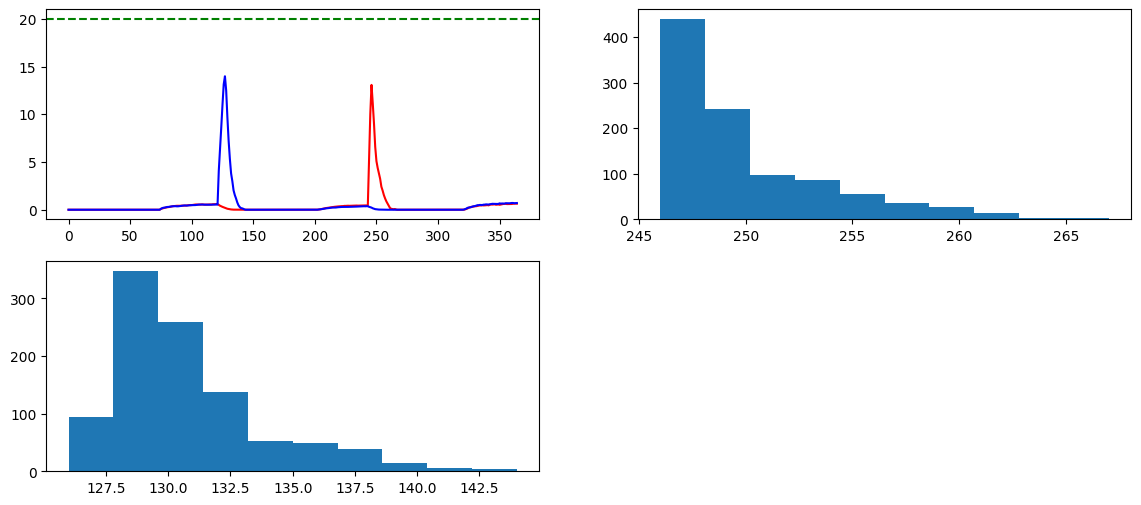

In [91]:
#BUILD CUMSUM CHARTS TO SHOW CHANGE DETECTION

plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.plot(cusum_ucb_mean_gpchart, color = 'r')
plt.plot(cusum_ucb_mean_gmchart, color = 'b')
plt.axhline(y = cusum_ucb_learner.conversion_rate_learner.h , color = 'g', linestyle = 'dashed')


plt.subplot(2,2,2)
plt.hist(p_detections)
print('number of positive detections: ' + str(len(p_detections)))


plt.subplot(2,2,3)
plt.hist(m_detections)
print('number of negative detections: ' + str(len(m_detections)))



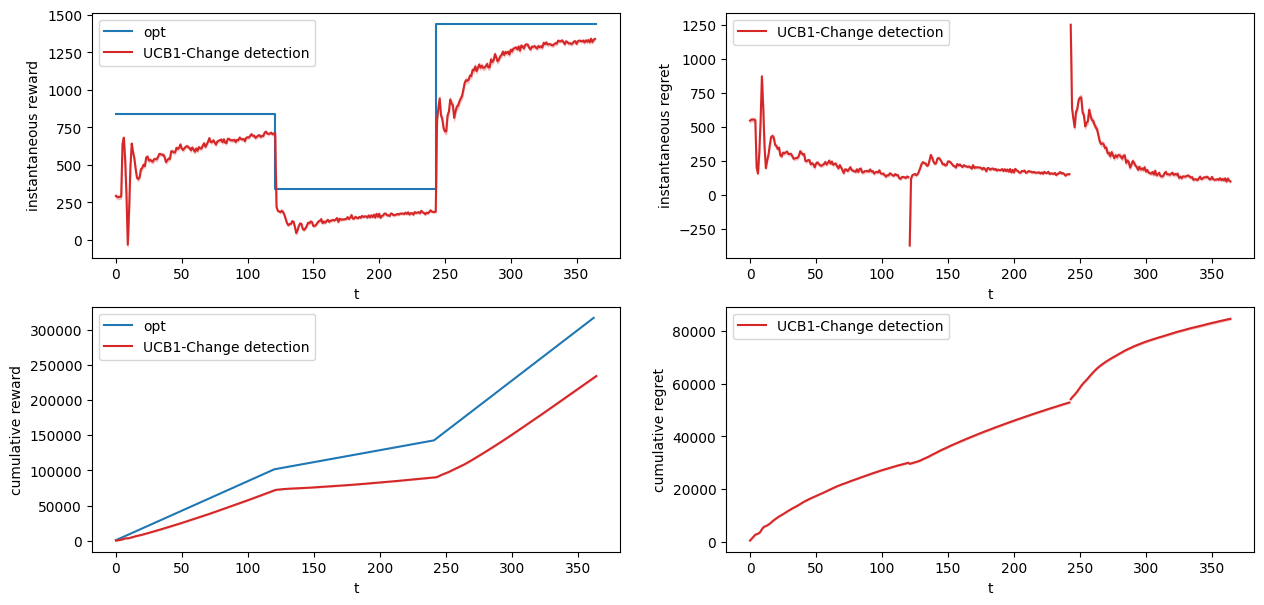

In [92]:
#Plots
plt.figure(figsize = (15,7))

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.step([0, int(T/3), int(2*T/3), T], [opt[0], opt[0], opt[1], opt[2]], label = 'opt')
plt.plot(cusum_ucb_mean_rewards_hat, color = 'C3', label = "UCB1-Change detection")
plt.fill_between(np.arange(T), cusum_ucb_mean_rewards_hat - cusum_ucb_std_inst, cusum_ucb_mean_rewards_hat + cusum_ucb_std_inst, alpha = 0.2, color = 'C3') 
plt.legend()

#Instantaneous regret plot
for i in range(3):
    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - cusum_ucb_mean_rewards_hat)[int(T*i/3):int(T*(i+1)/3)], color = "C3", label = "UCB1-Change detection")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - cusum_ucb_mean_rewards_hat - cusum_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], (opt[i] - cusum_ucb_mean_rewards_hat + cusum_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C3')
    if i == 0:
        plt.legend()
#plt.legend(['opt', 'EXP3', 'UCB1-Sliding window', 'UCB1-Change detection'])



#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")

temp = np.array([])
for i in range(0, 3):
    temp = np.append(temp, np.full(int(T/3), opt[i]))
plt.plot(np.cumsum(temp), label='opt')

plt.plot(np.cumsum(cusum_ucb_mean_rewards_hat), color = "C3", label = "UCB1-Change detection")
plt.fill_between(np.arange(T), np.cumsum(cusum_ucb_mean_rewards_hat) - cusum_ucb_std_cum, np.cumsum(cusum_ucb_mean_rewards_hat) + cusum_ucb_std_cum, alpha = 0.2, color = 'C3')

plt.legend()

#Cumulative regret plot 
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
temp_val_EXP3 = 0
temp_val_sw_UCB1 = 0
temp_val_cd_UCB1 = 0
for i in range(0, 3):
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)),temp_val_cd_UCB1+np.cumsum(opt[i] -  cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]), color = "C3", label = "UCB1-Change detection")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), temp_val_cd_UCB1+np.cumsum(opt[i] - cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) - cusum_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], temp_val_cd_UCB1+np.cumsum(opt[i] - cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) + cusum_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C3')
    temp_val_cd_UCB1 += np.sum(opt[i] -  cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)])
    if i == 0:
        plt.legend()

# Step 6

In [6]:
class EXP3_Learner(Learner):
    def __init__(self, n_arms, gamma):
        super().__init__(n_arms)
        self.weights = [1.0]*n_arms
        self.gamma = gamma

    def probability_distribution(self):
        sum_weights = sum(self.weights)
        return np.array([(1-self.gamma)*self.weights[i]/sum_weights + self.gamma/self.n_arms for i in range(self.n_arms)])

    def pull_arm(self):
        prob = self.probability_distribution()
        idx = np.random.choice(self.n_arms, p=prob)
        return idx, prob[idx]

    def estimated_rewards(self, reward_i, prob_i):
        return reward_i/prob_i
    
    def update(self, pulled_arm, prob_pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        # update weights
        est_reward_i = self.estimated_rewards(reward, prob_pulled_arm)
        self.weights[pulled_arm] = self.weights[pulled_arm]*np.exp(self.gamma*est_reward_i/self.n_arms)
        

class Custom_EXP3_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, cost, gamma):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.cost = cost

        self.conversion_rate_learner = EXP3_Learner(n_arms, gamma)

    def pull_arm(self):
        idx_arm, prob_idx = self.conversion_rate_learner.pull_arm()
        
        return idx_arm, prob_idx


    def update(self, pulled_arm, prob_pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        alpha = (reward + self.cum_daily_costs) / (self.n_daily_clicks)
        self.conversion_rate_learner.update(pulled_arm, prob_pulled_arm, alpha)

Training parameters

In [31]:
# Training parameters
T = 365
n_experiments = 1000
window_size = 4*int(np.sqrt(T))

n_phases = 3

# Gamma parameter EXP3
gamma = 0.25

BID_STEP1 = BIDS[55]

Clairvoyant

In [32]:
n_daily_clicks = int(C1_NS.n_daily_clicks_function(BID_STEP1))
cum_daily_costs = C1_NS.cum_daily_costs_function(BID_STEP1)

opt_val = [0]*3
for i in range(3):
    opt_val[i] = np.max(C1_NS.conversion_rate_function(PRICES)[i] * (PRICES - MARGIN_PARAM)) #optimal value of conversion rate between the arms for each phase

opt = [0]*3
for i in range(3):
    opt[i] = n_daily_clicks * opt_val[i] - cum_daily_costs

opt_arm = [0]*3
for i in range(3):
    opt_arm[i] = np.argmax(C1_NS.conversion_rate_function(PRICES)[i] * (PRICES - MARGIN_PARAM)) #optimal value of conversion rate between the arms for each phase

print("n_daily_clicks: ", n_daily_clicks)
print("cum_daily_costs: ", cum_daily_costs)
print()
print("optimal price phase 1: ", PRICES[opt_arm[0]])
print("optimal price phase 2: ", PRICES[opt_arm[1]])
print("optimal price phase 3: ", PRICES[opt_arm[2]])
print("conversion rate on the optimal price phase 1: ", C1_NS.conversion_rate_function(PRICES[opt_arm[0]])[0])
print("conversion rate on the optimal price phase 2: ", C1_NS.conversion_rate_function(PRICES[opt_arm[1]])[1])
print("conversion rate on the optimal price phase 3: ", C1_NS.conversion_rate_function(PRICES[opt_arm[2]])[2])
print("optimal reward phase 1: ", opt[0])
print("optimal reward phase 2: ", opt[1])
print("optimal reward phase 3: ", opt[2])

n_daily_clicks:  100
cum_daily_costs:  360.0

optimal price phase 1:  60
optimal price phase 2:  50
optimal price phase 3:  70
conversion rate on the optimal price phase 1:  0.5458775937413701
conversion rate on the optimal price phase 2:  0.9
conversion rate on the optimal price phase 3:  0.33109149705429813
optimal reward phase 1:  840.0
optimal reward phase 2:  340.0
optimal reward phase 3:  1440.0


In [33]:
## EXP3 learner
exp3_rewards_per_experiment = []

exp3_conversion_rate_hat = np.zeros(len(PRICES))
exp3_conversion_rate_bound = np.zeros(len(PRICES))


for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1_NS, T)
    exp3_learner = Custom_EXP3_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM, gamma)

    for t in range(0, T):       
        pulled_arm, prob_pulled_arm = exp3_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        exp3_learner.update(pulled_arm, prob_pulled_arm, reward)
    
    exp3_rewards_per_experiment.append(exp3_learner.collected_rewards)
    

exp3_std_inst = np.std(exp3_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
exp3_std_cum = np.std(np.cumsum(exp3_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

exp3_mean_rewards_hat = np.mean(exp3_rewards_per_experiment, axis = 0)

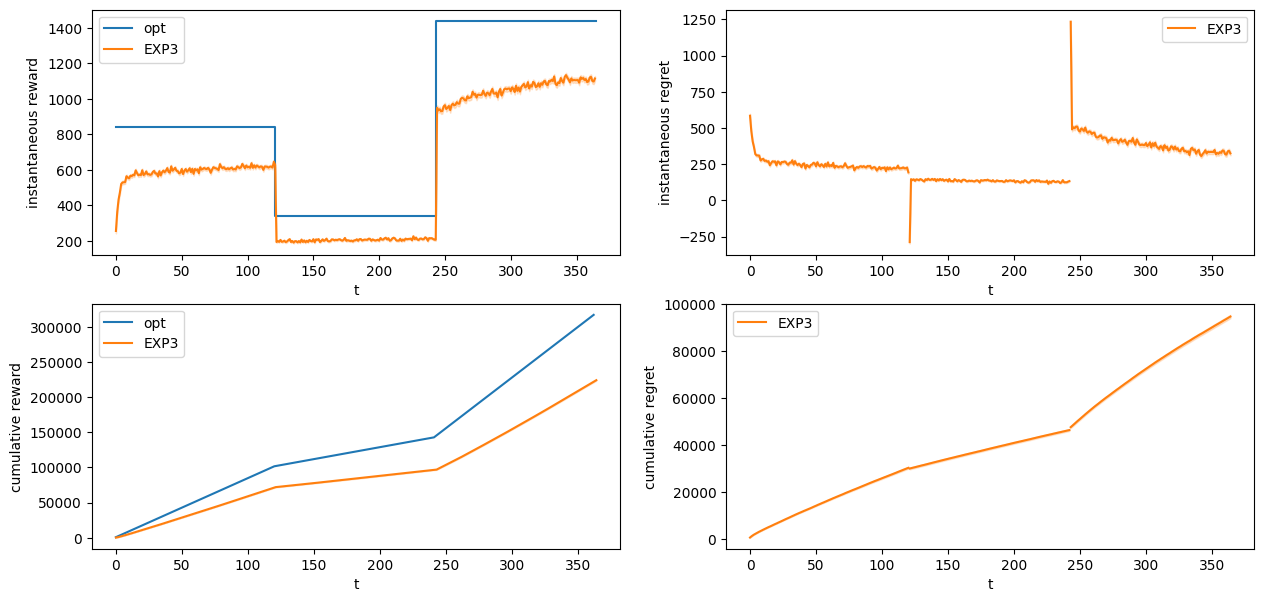

In [34]:
#Plots
plt.figure(figsize = (15,7))

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.step([0, int(T/3), int(2*T/3), T], [opt[0], opt[0], opt[1], opt[2]], label = 'opt')
plt.plot(exp3_mean_rewards_hat, color = 'C1', label = "EXP3")
plt.fill_between(np.arange(T), exp3_mean_rewards_hat - exp3_std_inst, exp3_mean_rewards_hat + exp3_std_inst, alpha = 0.2, color = 'C1')
plt.legend()

#Instantaneous regret plot
for i in range(n_phases):
    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - exp3_mean_rewards_hat)[int(T*i/3):int(T*(i+1)/3)], color = "C1", label='EXP3')
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - exp3_mean_rewards_hat - exp3_std_inst)[int(T*i/3):int(T*(i+1)/3)], (opt[i] - exp3_mean_rewards_hat + exp3_std_inst)[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C1')
    if i == 0:
        plt.legend()


#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")

temp = np.array([])
for i in range(0, n_phases):
    temp = np.append(temp, np.full(int(T/3), opt[i]))
plt.plot(np.cumsum(temp), label='opt')

plt.plot(np.cumsum(exp3_mean_rewards_hat), color = "C1", label = "EXP3")
plt.fill_between(np.arange(T), np.cumsum(exp3_mean_rewards_hat) - exp3_std_cum, np.cumsum(exp3_mean_rewards_hat) + exp3_std_cum, alpha = 0.2, color = 'C1')
plt.legend()

#Cumulative regret plot 
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
temp_val_EXP3 = 0
for i in range(0, n_phases):
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)),temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]), color = "C1", label = "EXP3")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) - exp3_std_cum[int(T*i/3):int(T*(i+1)/3)], temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) + exp3_std_cum[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C1')
    temp_val_EXP3 += np.sum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)])
    if i == 0:
        plt.legend()

In [24]:
## NS UCB1 - Sliding window
sw_ucb_rewards_per_experiment = []

sw_ucb_conversion_rate_hat = np.zeros(len(PRICES))
sw_ucb_conversion_rate_bound = np.zeros(len(PRICES)) 

## NS UCB1 - Change detection
cusum_ucb_rewards_per_experiment = []

cusum_ucb_conversion_rate_hat = np.zeros(len(PRICES))
cusum_ucb_conversion_rate_bound = np.zeros(len(PRICES))


for e in range(0, n_experiments):
    if e%100 == 0:
        print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1_NS, T)
    sw_ucb_learner = Custom_SW_UCB_Learner(PRICES, n_daily_clicks, cum_daily_costs, window_size)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = sw_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        sw_ucb_learner.update(pulled_arm, reward)
        
        
    sw_ucb_rewards_per_experiment.append(sw_ucb_learner.collected_rewards)
    sw_ucb_conversion_rate_hat += sw_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    sw_ucb_conversion_rate_bound += sw_ucb_learner.conversion_rate_learner.confidence/n_experiments 

for e in range(0, n_experiments):
    if e%100 == 0:
        print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1_NS, T)
    cusum_ucb_learner = Custom_CUSUM_UCB_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = cusum_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        cusum_ucb_learner.update(pulled_arm, reward)
        
    cusum_ucb_rewards_per_experiment.append(cusum_ucb_learner.collected_rewards)

    cusum_ucb_conversion_rate_hat += cusum_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    cusum_ucb_conversion_rate_bound += cusum_ucb_learner.conversion_rate_learner.confidence/n_experiments

sw_ucb_std_inst = np.std(sw_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
sw_ucb_std_cum = np.std(np.cumsum(sw_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

sw_ucb_mean_rewards_hat = np.mean(sw_ucb_rewards_per_experiment, axis = 0) 


cusum_ucb_std_inst = np.std(cusum_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
cusum_ucb_std_cum = np.std(np.cumsum(cusum_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

cusum_ucb_mean_rewards_hat = np.mean(cusum_ucb_rewards_per_experiment, axis = 0)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


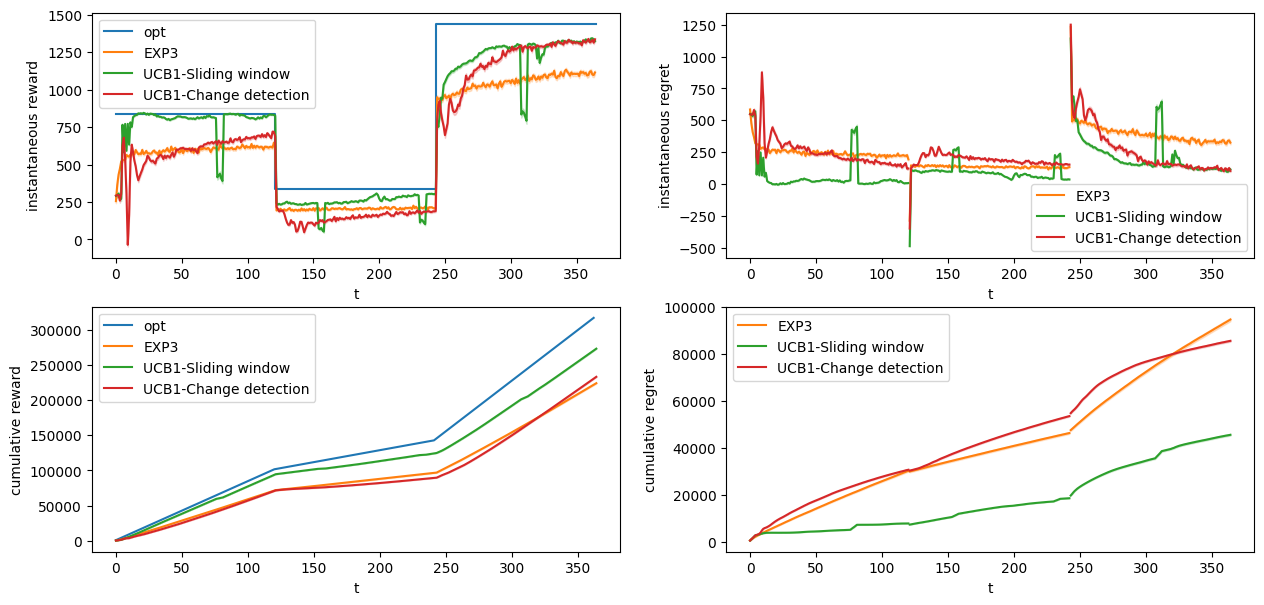

In [35]:
#Plots
plt.figure(figsize = (15,7))

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.step([0, int(T/3), int(2*T/3), T], [opt[0], opt[0], opt[1], opt[2]], label = 'opt')
plt.plot(exp3_mean_rewards_hat, color = 'C1', label = "EXP3")
plt.fill_between(np.arange(T), exp3_mean_rewards_hat - exp3_std_inst, exp3_mean_rewards_hat + exp3_std_inst, alpha = 0.2, color = 'C1')
plt.plot(sw_ucb_mean_rewards_hat, color = 'C2', label = "UCB1-Sliding window")
plt.fill_between(np.arange(T), sw_ucb_mean_rewards_hat - sw_ucb_std_inst, sw_ucb_mean_rewards_hat + sw_ucb_std_inst, alpha = 0.2, color = 'C2') 
plt.plot(cusum_ucb_mean_rewards_hat, color = 'C3', label = "UCB1-Change detection")
plt.fill_between(np.arange(T), cusum_ucb_mean_rewards_hat - cusum_ucb_std_inst, cusum_ucb_mean_rewards_hat + cusum_ucb_std_inst, alpha = 0.2, color = 'C3') 
plt.legend()

#Instantaneous regret plot
for i in range(n_phases):
    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - exp3_mean_rewards_hat)[int(T*i/3):int(T*(i+1)/3)], color = "C1", label='EXP3')
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - exp3_mean_rewards_hat - exp3_std_inst)[int(T*i/3):int(T*(i+1)/3)], (opt[i] - exp3_mean_rewards_hat + exp3_std_inst)[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C1')
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - sw_ucb_mean_rewards_hat)[int(T*i/3):int(T*(i+1)/3)], color = "C2", label = "UCB1-Sliding window")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - sw_ucb_mean_rewards_hat - sw_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], (opt[i] - sw_ucb_mean_rewards_hat + sw_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C2')
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - cusum_ucb_mean_rewards_hat)[int(T*i/3):int(T*(i+1)/3)], color = "C3", label = "UCB1-Change detection")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - cusum_ucb_mean_rewards_hat - cusum_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], (opt[i] - cusum_ucb_mean_rewards_hat + cusum_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C3')
    if i == 0:
        plt.legend()



#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")

temp = np.array([])
for i in range(0, n_phases):
    temp = np.append(temp, np.full(int(T/3), opt[i]))
plt.plot(np.cumsum(temp), label='opt')

plt.plot(np.cumsum(exp3_mean_rewards_hat), color = "C1", label = "EXP3")
plt.fill_between(np.arange(T), np.cumsum(exp3_mean_rewards_hat) - exp3_std_cum, np.cumsum(exp3_mean_rewards_hat) + exp3_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(sw_ucb_mean_rewards_hat), color = "C2", label = "UCB1-Sliding window")
plt.fill_between(np.arange(T), np.cumsum(sw_ucb_mean_rewards_hat) - sw_ucb_std_cum, np.cumsum(sw_ucb_mean_rewards_hat) + sw_ucb_std_cum, alpha = 0.2, color = 'C2')
plt.plot(np.cumsum(cusum_ucb_mean_rewards_hat), color = "C3", label = "UCB1-Change detection")
plt.fill_between(np.arange(T), np.cumsum(cusum_ucb_mean_rewards_hat) - cusum_ucb_std_cum, np.cumsum(cusum_ucb_mean_rewards_hat) + cusum_ucb_std_cum, alpha = 0.2, color = 'C3')

plt.legend()

#Cumulative regret plot 
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
temp_val_EXP3 = 0
temp_val_sw_UCB1 = 0
temp_val_cd_UCB1 = 0
for i in range(0, n_phases):
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)),temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]), color = "C1", label = "EXP3")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) - exp3_std_cum[int(T*i/3):int(T*(i+1)/3)], temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) + exp3_std_cum[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C1')
    temp_val_EXP3 += np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)])[-1]
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)),temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]), color = "C2", label = "UCB1-Sliding window")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) - sw_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) + sw_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C2')
    temp_val_sw_UCB1 += np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)])[-1]
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)),temp_val_cd_UCB1+np.cumsum(opt[i] -  cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]), color = "C3", label = "UCB1-Change detection")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), temp_val_cd_UCB1+np.cumsum(opt[i] - cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) - cusum_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], temp_val_cd_UCB1+np.cumsum(opt[i] - cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) + cusum_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C3')
    temp_val_cd_UCB1 += np.cumsum(opt[i] -  cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)])[-1]
    if i == 0:
        plt.legend()

## Higher degree of Non-Stationarity: 5 cyclical phases

Training parameters

In [80]:
# Training parameters
T = 365
n_experiments = 1000
window_size = 4*int(np.sqrt(T))
horizon = 50

n_phases = 5

# Gamma parameter EXP3
rho = 0.01
gamma = np.sqrt(3*np.log(2*len(PRICES)/rho)/(len(PRICES)*T))

BID_STEP1 = BIDS[55]

Clairvoyant

In [81]:
n_daily_clicks = int(C1_NS_5_phases.n_daily_clicks_function(BID_STEP1))
cum_daily_costs = C1_NS_5_phases.cum_daily_costs_function(BID_STEP1)

opt_val = [0]*n_phases
for i in range(n_phases):
    opt_val[i] = np.max(C1_NS_5_phases.conversion_rate_function(PRICES)[i] * (PRICES - MARGIN_PARAM)) #optimal value of conversion rate between the arms for each phase

opt = [0]*n_phases
for i in range(n_phases):
    opt[i] = n_daily_clicks * opt_val[i] - cum_daily_costs

opt_arm = [0]*n_phases
for i in range(n_phases):
    opt_arm[i] = np.argmax(C1_NS_5_phases.conversion_rate_function(PRICES)[i] * (PRICES - MARGIN_PARAM)) #optimal value of conversion rate between the arms for each phase


print("n_daily_clicks: ", n_daily_clicks)
print("cum_daily_costs: ", cum_daily_costs)
print()
print("optimal price phase 1: ", PRICES[opt_arm[0]])
print("optimal price phase 2: ", PRICES[opt_arm[1]])
print("optimal price phase 3: ", PRICES[opt_arm[2]])
print("optimal price phase 4: ", PRICES[opt_arm[3]])
print("optimal price phase 5: ", PRICES[opt_arm[4]])
print("conversion rate on the optimal price phase 1: ", C1_NS_5_phases.conversion_rate_function(PRICES[opt_arm[0]])[0])
print("conversion rate on the optimal price phase 2: ", C1_NS_5_phases.conversion_rate_function(PRICES[opt_arm[1]])[1])
print("conversion rate on the optimal price phase 3: ", C1_NS_5_phases.conversion_rate_function(PRICES[opt_arm[2]])[2])
print("conversion rate on the optimal price phase 4: ", C1_NS_5_phases.conversion_rate_function(PRICES[opt_arm[3]])[3])
print("conversion rate on the optimal price phase 5: ", C1_NS_5_phases.conversion_rate_function(PRICES[opt_arm[4]])[4])
print("optimal reward phase 1: ", opt[0])
print("optimal reward phase 2: ", opt[1])
print("optimal reward phase 3: ", opt[2])
print("optimal reward phase 4: ", opt[3])
print("optimal reward phase 5: ", opt[4])

n_daily_clicks:  100
cum_daily_costs:  360.0

optimal price phase 1:  60
optimal price phase 2:  80
optimal price phase 3:  50
optimal price phase 4:  60
optimal price phase 5:  70
conversion rate on the optimal price phase 1:  0.6
conversion rate on the optimal price phase 2:  0.85
conversion rate on the optimal price phase 3:  0.9
conversion rate on the optimal price phase 4:  0.35
conversion rate on the optimal price phase 5:  0.6
optimal reward phase 1:  840.0
optimal reward phase 2:  3040.0
optimal reward phase 3:  540.0
optimal reward phase 4:  340.0
optimal reward phase 5:  1440.0


In [82]:
## NS UCB1 - Sliding window
sw_ucb_rewards_per_experiment_5ph = []

sw_ucb_conversion_rate_hat_5ph  = np.zeros(len(PRICES))
sw_ucb_conversion_rate_bound_5ph = np.zeros(len(PRICES)) 

## NS UCB1 - Change detection
cusum_ucb_rewards_per_experiment_5ph = []

cusum_ucb_conversion_rate_hat_5ph = np.zeros(len(PRICES))
cusum_ucb_conversion_rate_bound_5ph = np.zeros(len(PRICES))

## EXP3 learner
exp3_rewards_per_experiment_5ph = []

exp3_conversion_rate_hat_5ph = np.zeros(len(PRICES))
exp3_conversion_rate_bound_5ph = np.zeros(len(PRICES))


for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1_NS_5_phases, horizon)
    sw_ucb_learner = Custom_SW_UCB_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM, window_size)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = sw_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        sw_ucb_learner.update(pulled_arm, reward)
        
        
    sw_ucb_rewards_per_experiment_5ph.append(sw_ucb_learner.collected_rewards)
    sw_ucb_conversion_rate_hat_5ph += sw_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    sw_ucb_conversion_rate_bound_5ph += sw_ucb_learner.conversion_rate_learner.confidence/n_experiments 

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1_NS_5_phases, horizon)
    cusum_ucb_learner = Custom_CUSUM_UCB_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = cusum_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        cusum_ucb_learner.update(pulled_arm, reward)
        
    cusum_ucb_rewards_per_experiment_5ph.append(cusum_ucb_learner.collected_rewards)

    cusum_ucb_conversion_rate_hat_5ph += cusum_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    cusum_ucb_conversion_rate_bound_5ph += cusum_ucb_learner.conversion_rate_learner.confidence/n_experiments

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1_NS_5_phases, horizon)
    exp3_learner = Custom_EXP3_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM, gamma)

    for t in range(0, T):       
        pulled_arm, prob_pulled_arm = exp3_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        exp3_learner.update(pulled_arm, prob_pulled_arm, reward)
    
    exp3_rewards_per_experiment_5ph.append(exp3_learner.collected_rewards)
    
sw_ucb_std_inst_5ph = np.std(sw_ucb_rewards_per_experiment_5ph, axis = 0)/np.sqrt(n_experiments)
sw_ucb_std_cum_5ph = np.std(np.cumsum(sw_ucb_rewards_per_experiment_5ph, axis = 1), axis = 0)/np.sqrt(n_experiments)

sw_ucb_mean_rewards_hat_5ph = np.mean(sw_ucb_rewards_per_experiment_5ph, axis = 0) 


cusum_ucb_std_inst_5ph = np.std(cusum_ucb_rewards_per_experiment_5ph, axis = 0)/np.sqrt(n_experiments)
cusum_ucb_std_cum_5ph = np.std(np.cumsum(cusum_ucb_rewards_per_experiment_5ph, axis = 1), axis = 0)/np.sqrt(n_experiments)

cusum_ucb_mean_rewards_hat_5ph = np.mean(cusum_ucb_rewards_per_experiment_5ph, axis = 0)


exp3_std_inst_5ph = np.std(exp3_rewards_per_experiment_5ph, axis = 0)/np.sqrt(n_experiments)
exp3_std_cum_5ph = np.std(np.cumsum(exp3_rewards_per_experiment_5ph, axis = 1), axis = 0)/np.sqrt(n_experiments)

exp3_mean_rewards_hat_5ph = np.mean(exp3_rewards_per_experiment_5ph, axis = 0)

In [77]:
"""
# prove per EXP3
gamma = 0.2

exp3_rewards_per_experiment_5ph = []

exp3_conversion_rate_hat_5ph = np.zeros(len(PRICES))
exp3_conversion_rate_bound_5ph = np.zeros(len(PRICES))

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1_NS_5_phases, horizon)
    exp3_learner = Custom_EXP3_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM, gamma)

    for t in range(0, T):       
        pulled_arm, prob_pulled_arm = exp3_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        exp3_learner.update(pulled_arm, prob_pulled_arm, reward)
    
    exp3_rewards_per_experiment_5ph.append(exp3_learner.collected_rewards)

exp3_std_inst_5ph = np.std(exp3_rewards_per_experiment_5ph, axis = 0)/np.sqrt(n_experiments)
exp3_std_cum_5ph = np.std(np.cumsum(exp3_rewards_per_experiment_5ph, axis = 1), axis = 0)/np.sqrt(n_experiments)

exp3_mean_rewards_hat_5ph = np.mean(exp3_rewards_per_experiment_5ph, axis = 0)
"""

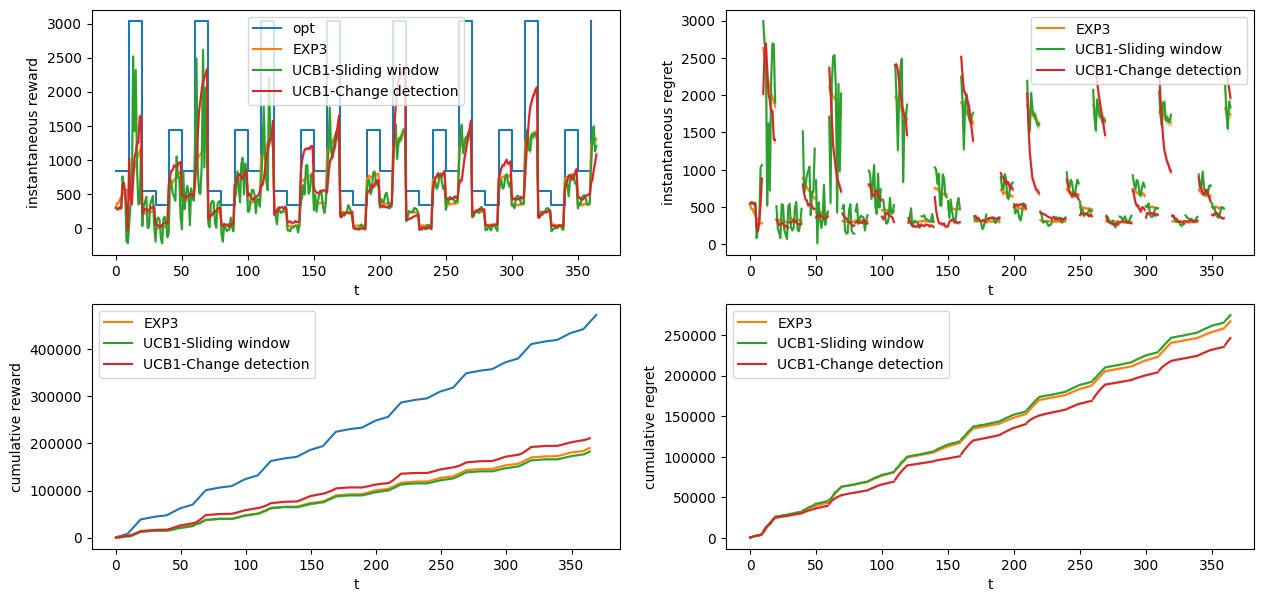

In [83]:
#Plots
plt.figure(figsize = (15,7))
phases = []
for i in range(math.ceil(T/horizon)):
    phases.extend([0,1,2,3,4])
phases = phases[:math.ceil(T/ns_env.phase_size)]

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
opt_vec = [opt[0]]
opt_vec.extend([opt[i] for i in phases])
opt_T = [i*horizon/5 for i in range(len(phases))]
opt_T.append(opt_T[-1])
plt.step(opt_T, opt_vec, label = 'opt')
plt.plot(exp3_mean_rewards_hat_5ph, color = 'C1', label = "EXP3")
plt.fill_between(np.arange(T), exp3_mean_rewards_hat_5ph - exp3_std_inst_5ph, exp3_mean_rewards_hat_5ph + exp3_std_inst_5ph, alpha = 0.2, color = 'C1')
plt.plot(sw_ucb_mean_rewards_hat_5ph, color = 'C2', label = "UCB1-Sliding window")
plt.fill_between(np.arange(T), sw_ucb_mean_rewards_hat_5ph - sw_ucb_std_inst_5ph, sw_ucb_mean_rewards_hat_5ph + sw_ucb_std_inst_5ph, alpha = 0.2, color = 'C2') 
plt.plot(cusum_ucb_mean_rewards_hat_5ph, color = 'C3', label = "UCB1-Change detection")
plt.fill_between(np.arange(T), cusum_ucb_mean_rewards_hat_5ph - cusum_ucb_std_inst_5ph, cusum_ucb_mean_rewards_hat_5ph + cusum_ucb_std_inst_5ph, alpha = 0.2, color = 'C3') 
plt.legend()

#Instantaneous regret plot
count = 0
phase_size = int(ns_env.phase_size)
add_phase = phase_size
for i in phases:
    if count+add_phase > len(exp3_mean_rewards_hat_5ph):
        add_phase = add_phase - (count + add_phase - len(exp3_mean_rewards_hat_5ph))
    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(np.arange(count, count+add_phase), (opt[i] - exp3_mean_rewards_hat_5ph)[count:count+add_phase], color = "C1", label='EXP3')
    plt.fill_between(np.arange(count, count+add_phase), (opt[i] - exp3_mean_rewards_hat_5ph - exp3_std_inst_5ph)[count:count+add_phase], (opt[i] - exp3_mean_rewards_hat_5ph + exp3_std_inst_5ph)[count:count+add_phase], alpha = 0.2, color = 'C1')
    plt.plot(np.arange(count, count+add_phase), (opt[i] - sw_ucb_mean_rewards_hat_5ph)[count:count+add_phase], color = "C2", label = "UCB1-Sliding window")
    plt.fill_between(np.arange(count, count+add_phase), (opt[i] - sw_ucb_mean_rewards_hat_5ph - sw_ucb_std_inst_5ph)[count:count+add_phase], (opt[i] - sw_ucb_mean_rewards_hat_5ph + sw_ucb_std_inst_5ph)[count:count+add_phase], alpha = 0.2, color = 'C2')
    plt.plot(np.arange(count, count+add_phase), (opt[i] - cusum_ucb_mean_rewards_hat_5ph)[count:count+add_phase], color = "C3", label = "UCB1-Change detection")
    plt.fill_between(np.arange(count, count+add_phase), (opt[i] - cusum_ucb_mean_rewards_hat_5ph - cusum_ucb_std_inst_5ph)[count:count+add_phase], (opt[i] - cusum_ucb_mean_rewards_hat_5ph + cusum_ucb_std_inst_5ph)[count:count+add_phase], alpha = 0.2, color = 'C3')
    if count == 0:
        plt.legend()
    count += add_phase

#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")

temp = np.array([])
for i in phases:
    temp = np.append(temp, np.full(phase_size, opt[i]))
plt.plot(np.cumsum(temp))

plt.plot(np.cumsum(exp3_mean_rewards_hat_5ph), color = "C1", label = "EXP3")
plt.fill_between(np.arange(T), np.cumsum(exp3_mean_rewards_hat_5ph) - exp3_std_cum_5ph, np.cumsum(exp3_mean_rewards_hat_5ph) + exp3_std_cum_5ph, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(sw_ucb_mean_rewards_hat_5ph), color = "C2", label = "UCB1-Sliding window")
plt.fill_between(np.arange(T), np.cumsum(sw_ucb_mean_rewards_hat_5ph) - sw_ucb_std_cum_5ph, np.cumsum(sw_ucb_mean_rewards_hat_5ph) + sw_ucb_std_cum_5ph, alpha = 0.2, color = 'C2')
plt.plot(np.cumsum(cusum_ucb_mean_rewards_hat_5ph), color = "C3", label = "UCB1-Change detection")
plt.fill_between(np.arange(T), np.cumsum(cusum_ucb_mean_rewards_hat_5ph) - cusum_ucb_std_cum_5ph, np.cumsum(cusum_ucb_mean_rewards_hat_5ph) + cusum_ucb_std_cum_5ph, alpha = 0.2, color = 'C3')
plt.legend()


#Cumulative regret plot 
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
temp_val_EXP3 = 0
temp_val_sw_UCB1 = 0
temp_val_cd_UCB1 = 0
count = 0
add_phase = phase_size
for i in phases:
    if count+add_phase > len(exp3_mean_rewards_hat_5ph):
        add_phase = add_phase - (count+add_phase - len(exp3_mean_rewards_hat_5ph))
    plt.plot(np.arange(count, count+add_phase),temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat_5ph[count:count+add_phase]), color = "C1", label = "EXP3")
    plt.fill_between(np.arange(count, count+add_phase), temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat_5ph[count:count+add_phase]) - exp3_std_cum_5ph[count:count+add_phase], temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat_5ph[count:count+add_phase]) + exp3_std_cum_5ph[count:count+add_phase], alpha = 0.2, color = 'C1')
    temp_val_EXP3 += np.cumsum(opt[i] - exp3_mean_rewards_hat_5ph[count:count+add_phase])[-1]
    plt.plot(np.arange(count, count+add_phase),temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat_5ph[count:count+add_phase]), color = "C2", label = "UCB1-Sliding window")
    plt.fill_between(np.arange(count, count+add_phase), temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat_5ph[count:count+add_phase]) - sw_ucb_std_cum_5ph[count:count+add_phase], temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat_5ph[count:count+add_phase]) + sw_ucb_std_cum_5ph[count:count+add_phase], alpha = 0.2, color = 'C2')
    temp_val_sw_UCB1 += np.cumsum(opt[i] - sw_ucb_mean_rewards_hat_5ph[count:count+add_phase])[-1]
    plt.plot(np.arange(count, count+add_phase),temp_val_cd_UCB1+np.cumsum(opt[i] -  cusum_ucb_mean_rewards_hat_5ph[count:count+add_phase]), color = "C3", label = "UCB1-Change detection")
    plt.fill_between(np.arange(count, count+add_phase), temp_val_cd_UCB1+np.cumsum(opt[i] - cusum_ucb_mean_rewards_hat_5ph[count:count+add_phase]) - cusum_ucb_std_cum_5ph[count:count+add_phase], temp_val_cd_UCB1+np.cumsum(opt[i] - cusum_ucb_mean_rewards_hat_5ph[count:count+add_phase]) + cusum_ucb_std_cum_5ph[count:count+add_phase], alpha = 0.2, color = 'C3')
    temp_val_cd_UCB1 += np.cumsum(opt[i] -  cusum_ucb_mean_rewards_hat_5ph[count:count+add_phase])[-1]
    if count == 0:
        plt.legend()
    count += add_phase